# Homework 5: Transaction Costs & Asian Options

<p style="text-align: left; font-size: 18pt; color: orange;">
    <i>Done by<br>Maksim Kuptsov, DSBA231</i>
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

np.random.seed(42)
plt.rcParams["figure.figsize"] = (10, 6)

---
## **Problem 1: Leland Model & Transaction Costs (5 points)**

You are a derivatives trader who sold a European call option and needs to hedge it by rebalancing a delta-hedged portfolio. However, each trade incurs proportional transaction costs.

**Market Parameters:**
- Current stock price: $S_0 = 100$
- Strike price: $K = 100$
- Time to maturity: $T = 1$ year
- Risk-free rate: $r = 5\%$
- True volatility: $\sigma = 20\%$
- Proportional transaction cost: $k = 0.001$ (10 basis points)

---

### $\textcolor{lightblue}{\textbf{Part (a): Theory (1.5 points)}}$

**(i)** Explain why continuous hedging is impossible when transaction costs are present. What happens to the total hedging cost as $\Delta t \to 0$?

**(ii)** Write down the **Leland effective volatility formula** (Version I) for a long gamma position.

Explain the economic intuition: why does $\sigma_L > \sigma$ when we have transaction costs and positive gamma?

**(iii)** Mention one major limitation of the Leland model.

$\textcolor{green}{\textbf{Answer}}$

Let me be concise.

(i)
Every time we rebalance, we pay a cost proportional to the trade size. \
As $\Delta t \to 0$, total cost, which behaves roughly like $\frac{1}{\sqrt{\Delta t}}$, converges to $\infty$, making continuous hedging infinitely expensive and thus impossible.

(ii)
$$
\sigma_L^2 = \sigma^2 + 2k\sigma\sqrt{\frac{2}{\pi\Delta t}}
$$
Positive gamma means we must rebalance often (buy when price falls, sell when it rises).
Rebalancing means trading, which leads to transaction costs.
Leland represents these extra costs as if the world had **higher** volatility, which increases the option’s value.

(iii)
Besides impossibility of continuous hedging, the major limitation in its rough approximation, it simply adjusts volatility rather than modelling the full impact of transaction costs. \
In real markets deviation of simple proportional-cost assumption from market frictions, like spreads and liquidity, leads to inaccurate approximation.

---

### $\textcolor{lightblue}{\textbf{Part (b): Leland Volatility Calculation (1.5 points)}}$

Assume you rebalance your hedge **weekly** (i.e., $\Delta t = \frac{1}{52}$).

**(i)** Implement a function to compute the Leland effective volatility $\sigma_L$ given $\sigma$, $k$, and $\Delta t$.

**(ii)** Calculate $\sigma_L$ for weekly rebalancing with the parameters above.

**(iii)** Compute the Black–Scholes call option prices using:
- True volatility $\sigma = 0.20$
- Leland volatility $\sigma_L$ (from part ii)

Report the percentage difference between the two prices.

In [59]:
def bs_call(S0, K, T, r, q, sigma):
    '''Black-Scholes call price function'''

    if T <= 0:
        return max(S0 - K, 0)

    d1 = (np.log(S0/K) + (r - q + 0.5*sigma**2) * T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    return S0 * np.exp(-q*T) * st.norm.cdf(d1) - K * np.exp(-r*T) * st.norm.cdf(d2)


def leland_volatility(sigma, k, dt):
    '''Leland effective volatility function'''

    sigma_L_squared = sigma**2 + (
        2 * k * sigma * np.sqrt(2 / (np.pi * dt))
    )
    return np.sqrt(sigma_L_squared)


# Parameters
S0 = 100
K = 100
T = 1
r = 0.05
q = 0.0
sigma = 0.20
k = 0.001
dt_weekly = 1/52

sigma_L = leland_volatility(sigma, k, dt_weekly)
print(f'sigma_L for weekly rebalancing: {sigma_L:.4f}\n')

bs_call_price = bs_call(S0, K, T, r, q, sigma)
leland_call_price = bs_call(S0, K, T, r, q, sigma_L)

print(f'BS call price:\t\t{bs_call_price:.4f}')
print(f'Leland call price:\t{leland_call_price:.4f}')
print(f'Percentage difference:\t{(leland_call_price - bs_call_price)/bs_call_price*100:.4f}% [BS -> Leland]')


sigma_L for weekly rebalancing: 0.2057

BS call price:		10.4506
Leland call price:	10.6636
Percentage difference:	2.0385% [BS -> Leland]


---

### $\textcolor{lightblue}{\textbf{Part (c): Sensitivity Analysis (2 points)}}$

Analyze how the Leland effective volatility $\sigma_L$ depends on the rebalancing frequency.

**(i)** Compute $\sigma_L$ for the following rebalancing frequencies:
- Daily: $\Delta t = \frac{1}{252}$
- Weekly: $\Delta t = \frac{1}{52}$
- Monthly: $\Delta t = \frac{1}{12}$
- Quarterly: $\Delta t = \frac{1}{4}$

**(ii)** Create a plot showing $\sigma_L$ vs. $\Delta t$ (use appropriate x-axis scaling).

**(iii)** Compute the corresponding option prices for each $\Delta t$ and create a second plot showing how the option price varies with rebalancing frequency.

**(iv)** Briefly interpret your results: what happens to the option price as we rebalance less frequently? Why?

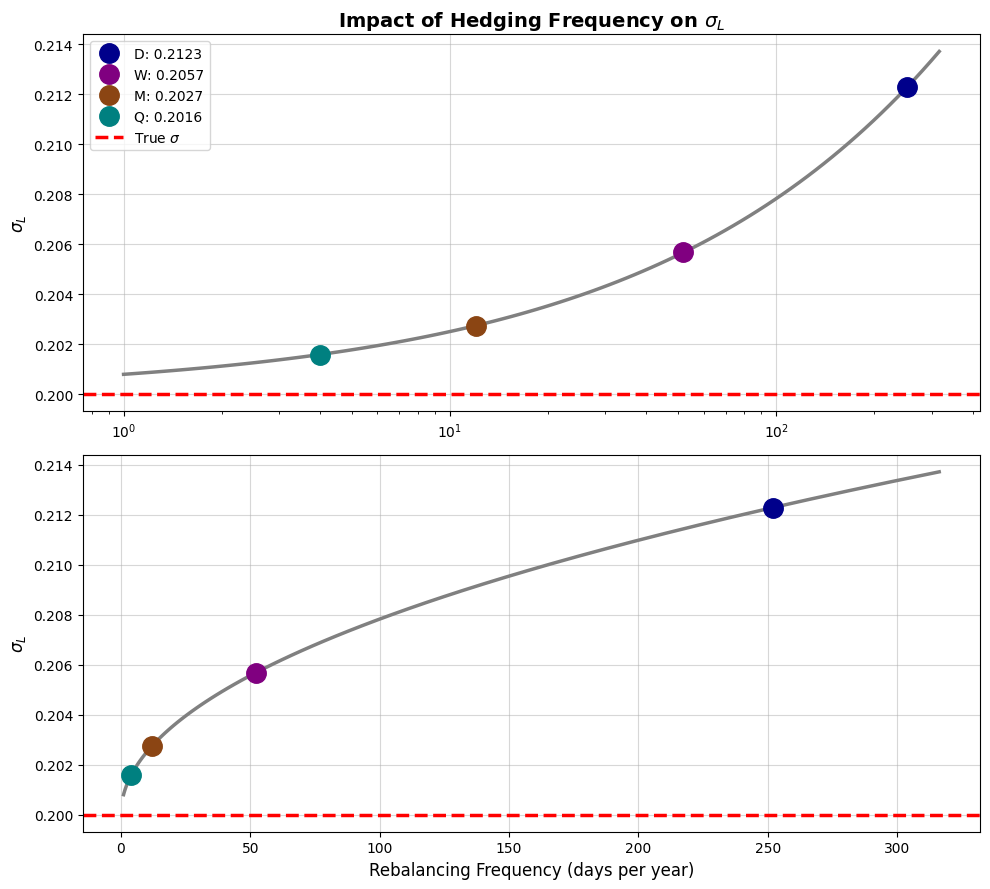

In [60]:
dts = np.array([1/252, 1/52, 1/12, 1/4])
sigma_Ls = [leland_volatility(sigma, k, dt) for dt in dts]

fig, axes = plt.subplots(2, 1, figsize=(10, 9))

# Continuous line
freq_space = np.logspace(0, 2.5, 100)
axes[0].plot(
    freq_space,
    [leland_volatility(sigma, k, dt) for dt in 1/freq_space],
    linewidth=2.5, color='grey'
)
# Key dts points
axes[0].plot(1/dts[0], sigma_Ls[0], 'o ', markersize=14, color='darkblue', label=f'D: {sigma_Ls[0]:.4f}')
axes[0].plot(1/dts[1], sigma_Ls[1], 'o ', markersize=14, color='purple', label=f'W: {sigma_Ls[1]:.4f}')
axes[0].plot(1/dts[2], sigma_Ls[2], 'o ', markersize=14, color='saddlebrown', label=f'M: {sigma_Ls[2]:.4f}')
axes[0].plot(1/dts[3], sigma_Ls[3], 'o ', markersize=14, color='teal', label=f'Q: {sigma_Ls[3]:.4f}')

# True sigma
axes[0].axhline(sigma, color='red', linestyle='--', linewidth=2.5, label=r'True $\sigma$')
axes[0].set_xscale('log')
axes[0].set_ylabel(r'$\sigma_L$', fontsize=12)
axes[0].set_title(r'Impact of Hedging Frequency on $\sigma_L$', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.5)
axes[0].legend()

# Continuous line
freq_space = np.logspace(0, 2.5, 100)
axes[1].plot(
    freq_space,
    [leland_volatility(sigma, k, dt) for dt in 1/freq_space],
    linewidth=2.5, color='grey'
)
# Key dts points
axes[1].plot(1/dts[0], sigma_Ls[0], 'o ', markersize=14, color='darkblue', label=f'D: {sigma_Ls[0]:.4f}')
axes[1].plot(1/dts[1], sigma_Ls[1], 'o ', markersize=14, color='purple', label=f'W: {sigma_Ls[1]:.4f}')
axes[1].plot(1/dts[2], sigma_Ls[2], 'o ', markersize=14, color='saddlebrown', label=f'M: {sigma_Ls[2]:.4f}')
axes[1].plot(1/dts[3], sigma_Ls[3], 'o ', markersize=14, color='teal', label=f'Q: {sigma_Ls[3]:.4f}')
# True sigma
axes[1].axhline(sigma, color='red', linestyle='--', linewidth=2.5, label=r'True $\sigma$')
axes[1].set_ylabel(r'$\sigma_L$', fontsize=12)
axes[1].set_xlabel('Rebalancing Frequency (days per year)', fontsize=12)
axes[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

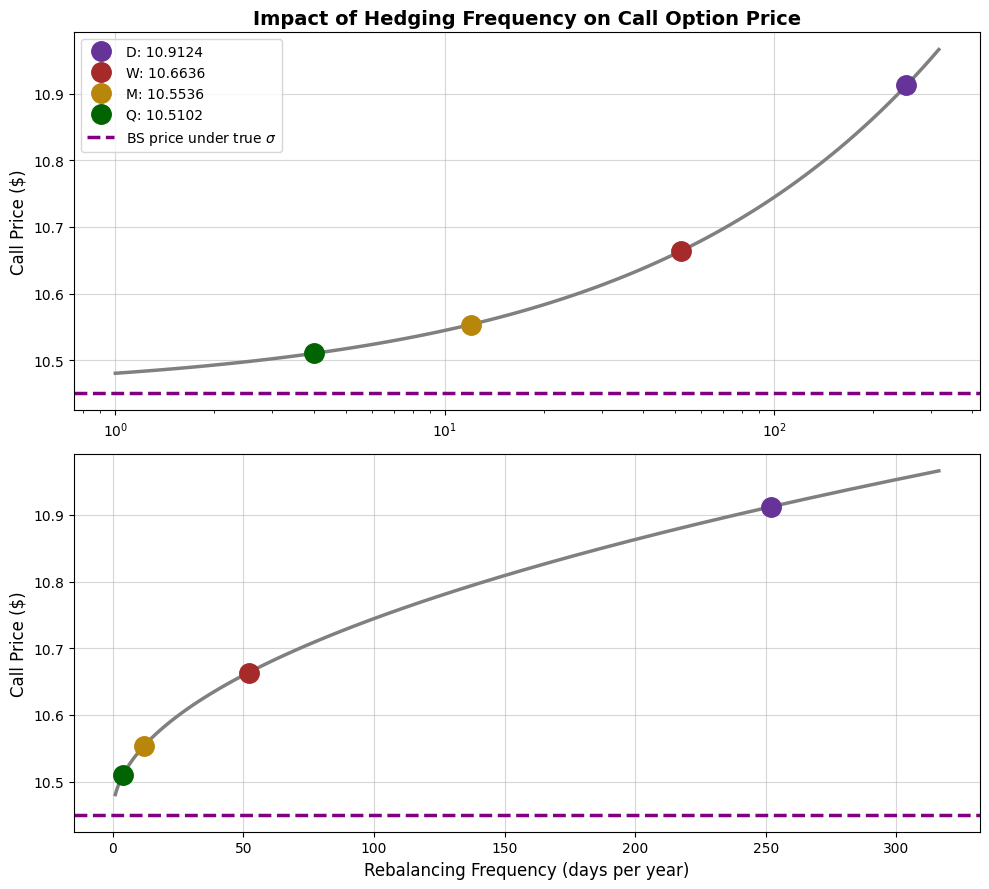

In [61]:
leland_prices = [bs_call(S0, K, T, r, q, sl) for sl in sigma_Ls]
bs_call_price = bs_call(S0, K, T, r, q, sigma)


fig, axes = plt.subplots(2, 1, figsize=(10, 9))

# Continuous line
freq_space = np.logspace(0, 2.5, 100)
axes[0].plot(
    freq_space,
    [bs_call(S0, K, T, r, q, leland_volatility(sigma, k, dt)) for dt in 1/freq_space],
    linewidth=2.5, color='grey'
)
# Key dts points
axes[0].plot(1/dts[0], leland_prices[0], 'o ', markersize=14, color='rebeccapurple', label=f'D: {leland_prices[0]:.4f}')
axes[0].plot(1/dts[1], leland_prices[1], 'o ', markersize=14, color='brown', label=f'W: {leland_prices[1]:.4f}')
axes[0].plot(1/dts[2], leland_prices[2], 'o ', markersize=14, color='darkgoldenrod', label=f'M: {leland_prices[2]:.4f}')
axes[0].plot(1/dts[3], leland_prices[3], 'o ', markersize=14, color='darkgreen', label=f'Q: {leland_prices[3]:.4f}')

# BS
axes[0].axhline(bs_call_price, color='purple', linestyle='--', linewidth=2.5, label=r'BS price under true $\sigma$')
axes[0].set_xscale('log')
axes[0].set_ylabel('Call Price ($)', fontsize=12)
axes[0].set_title('Impact of Hedging Frequency on Call Option Price', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.5)
axes[0].legend()

# Continuous line
freq_space = np.logspace(0, 2.5, 100)
axes[1].plot(
    freq_space,
    [bs_call(S0, K, T, r, q, leland_volatility(sigma, k, dt)) for dt in 1/freq_space],
    linewidth=2.5, color='grey'
)
# Key dts points
axes[1].plot(1/dts[0], leland_prices[0], 'o ', markersize=14, color='rebeccapurple', label=f'D: {leland_prices[0]:.4f}')
axes[1].plot(1/dts[1], leland_prices[1], 'o ', markersize=14, color='brown', label=f'W: {leland_prices[1]:.4f}')
axes[1].plot(1/dts[2], leland_prices[2], 'o ', markersize=14, color='darkgoldenrod', label=f'M: {leland_prices[2]:.4f}')
axes[1].plot(1/dts[3], leland_prices[3], 'o ', markersize=14, color='darkgreen', label=f'Q: {leland_prices[3]:.4f}')

# BS
axes[1].axhline(bs_call_price, color='purple', linestyle='--', linewidth=2.5, label=r'BS price under true $\sigma$')
axes[1].set_xlabel('Rebalancing Frequency (days per year)', fontsize=12)
axes[1].set_ylabel('Call Price ($)', fontsize=12)
axes[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

$\textcolor{green}{\textbf{Interpretation}}$

Leland effective volatility rises as we rebalance more frequntly, and so does the option price, because it is known to positively correlate with volatility. The grater volatility is, the grater the probabily for the option to end up in-the-money is, thus its price increases.

We can ensure that observing the relationship between the option price and volatility:

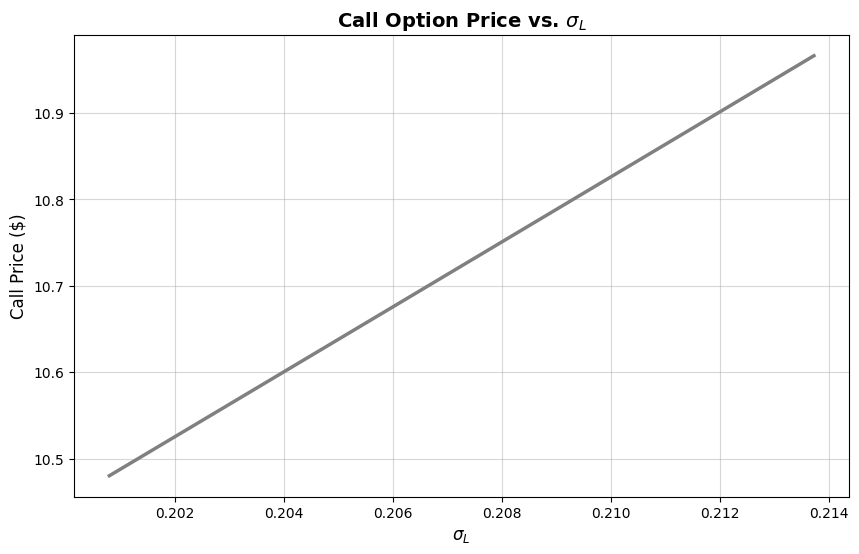

In [65]:
plt.plot(
    [leland_volatility(sigma, k, dt) for dt in 1/freq_space],
    [bs_call(S0, K, T, r, q, leland_volatility(sigma, k, dt)) for dt in 1/freq_space],
    linewidth=2.5, color='grey'
)

plt.xlabel(r'$\sigma_L$', fontsize=12)
plt.ylabel('Call Price ($)', fontsize=12)
plt.title(r'Call Option Price vs. $\sigma_L$', fontsize=14, fontweight='bold')
plt.grid(alpha=0.5)
plt.show()

---
---

## **Problem 2: Asian Options (5 points)**

Asian options have payoffs that depend on the **average price** of the underlying asset over a period, rather than just the final price.

**Market Parameters:**
- Current stock price: $S_0 = 100$
- Strike price: $K = 100$
- Time to maturity: $T = 1$ year
- Risk-free rate: $r = 5\%$
- Dividend yield: $q = 0$
- Volatility: $\sigma = 25\%$

---

### $\textcolor{lightblue}{\textbf{Part (a): Theory (1.5 points)}}$

**(i)** Write the payoff formula for an **arithmetic Asian call option** with continuous averaging.

**(ii)** Explain why Asian options are typically **cheaper** than vanilla European call options with the same strike and maturity. What is the key financial reason?

**(iii)** What is the main pricing advantage of **geometric** Asian options over **arithmetic** Asian options?

$\textcolor{green}{\textbf{Answer}}$

(i)
$$
\text{Payoff} = \left(A_T^{\text{arith}} - K\right)^+ = \left(\frac{1}{T}\int_0^T S_t\,dt - K\right)^+
$$

(ii)
The key financial reason is volatility reduction due to averaging. \
An Asian call depends on an average of the underlying price path $S_t$: $\hspace{1mm} A_T$. Averaging smooths fluctuations, lowers volatility of the payoff, and therefore reduces the option’s time value. As usual, lower volatility implies lower option price. 

(iii)
Geometric Asian averages lead to a lognormal distribution under the Black–Scholes assumptions.
This yields a **closed-form** solution for Geometric Asian option prices. \
In contrast, Arithmetic Asian options require **numerical methods**.

---

### $\textcolor{lightblue}{\textbf{Part (b): Monte Carlo Pricing (2.5 points)}}$

Price the arithmetic Asian call option using **Monte Carlo simulation**.

**(i)** Simulate $N = 10{,}000$ paths of the stock price $S_t$ over $[0, T]$ using the Euler scheme:

$$S_{t+\Delta t} = S_t + rS_t\Delta t + \sigma S_t \sqrt{\Delta t} \, Z$$

where $Z \sim N(0,1)$. Use $n = 252$ time steps (daily observations).

**(ii)** For each simulated path, compute the arithmetic average:

$$A_T^{\text{arith}} \approx \frac{1}{n}\sum_{i=1}^{n} S_{t_i}$$

(Or use the trapezoidal rule for better accuracy.)

**(iii)** Compute the payoff for each path: $X^{(j)} = \left(A_T^{\text{arith},(j)} - K\right)^+$

**(iv)** Estimate the option price:

$$V_0 = e^{-rT} \cdot \frac{1}{N}\sum_{j=1}^{N} X^{(j)}$$

**(v)** Report the estimated price and the Monte Carlo standard error:

$$\text{SE} = \frac{s}{\sqrt{N}}$$

where $s$ is the sample standard deviation of the discounted payoffs.

In [36]:
def euler_maruyama(X0, r, sigma, T, N):
    dt = T/N
    X = np.zeros(N+1)
    X[0] = X0
    for i in range(N):
        X[i+1] = X[i] + r*X[i]*dt + sigma*X[i]*np.random.randn()*np.sqrt(dt)
    return np.linspace(0, T, N+1), X

In [38]:
def arithmetic_asian_call_mc(S0, K, T, r, sigma, N, M):
    '''
    Monte Carlo pricing of arithmetic Asian call option.
    N - number of time steps
    M - number of simulated paths
    '''

    payoffs = np.zeros(M)

    for i in range(M):
        _, prices = euler_maruyama(S0, r, sigma, T, N)
        avg_price = np.mean(prices[1:]) # Excluding initial price
        payoffs[i] = max(avg_price - K, 0)

    # Discount and average
    price = np.exp(-r*T) * np.mean(payoffs)
    std_error = np.exp(-r*T) * np.std(payoffs) / np.sqrt(M)

    return price, std_error

In [39]:
# Parameters
S0 = 100
K = 100
T = 1
r = 0.05
q = 0.0
sigma = 0.25
M = 10000
n_steps = 252
dt = T / n_steps

arith_asian_call_mc_price, std_error = arithmetic_asian_call_mc(S0, K, T, r, sigma, n_steps, M)
print(f'Price Arithmetic Asian Call using Monte Carlo:\n${arith_asian_call_mc_price:.4f} ± ${std_error:.4f}')

Price Arithmetic Asian Call using Monte Carlo:
$6.7583 ± $0.0983


---

### $\textcolor{lightblue}{\textbf{Part (c): Comparison with Vanilla Option (1 point)}}$

**(i)** Price a standard **European call option** with the same parameters ($S_0=100, K=100, T=1, r=5\%, \sigma=25\%$) using the Black–Scholes formula.

**(ii)** Compare the prices:
- Asian call price (from part b)
- European call price

**(iii)** Compute the percentage difference:

$$\text{Difference} = \frac{C_{\text{European}} - C_{\text{Asian}}}{C_{\text{European}}} \times 100\%$$

**(iv)** Explain why the Asian option is cheaper (relate to your answer in part (a)(ii)).

In [47]:
vanilla_call = bs_call(S0, K, T, r, q, sigma)
comparison = pd.DataFrame({
    'European Call Price ($)': [np.around(vanilla_call, decimals=4)],
    'Arithmetic Asian Call Price ($)': [np.around(arith_asian_call_mc_price, decimals=4)],
    'Difference (%)': [np.around((vanilla_call - arith_asian_call_mc_price) / vanilla_call * 100, decimals=4)]
})
comparison

,European Call Price ($),Arithmetic Asian Call Price ($),Difference (%)
0,12.336,6.7583,45.2149


As explained in (a)(ii) and Problem1 (c)(iv), Asian option is cheaper, because it implies lower volatility due to averaging in the underlying process. The same rule applies here: the lower the volatility is, the lower option price is.